<a href="https://colab.research.google.com/github/Dhanush-S-Gowda/GenderClassifierYolo/blob/main/genderClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 22.8 MB/s eta 0:00:00


In [2]:
import os
from zipfile import ZipFile
import shutil

In [3]:
kaggle_json_path = '/content/kaggle.json'

if not os.path.exists(kaggle_json_path):
    from google.colab import files
    print("Upload your kaggle.json file")
    files.upload()

Upload your kaggle.json file


Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d cashutosh/gender-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset
License(s): other
 98% 265M/269M [00:02<00:00, 105MB/s]
100% 269M/269M [00:02<00:00, 118MB/s]


In [6]:
dataset_zip_path = 'gender-classification-dataset.zip'
dataset_path = '/content/gender-classification-dataset'

In [7]:
with ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

In [8]:
def create_yolo_format(src_dir, dest_dir, label_map):
    """
    Convert dataset to YOLO format.
    src_dir: Source directory with images
    dest_dir: Destination directory for YOLO format data
    label_map: Dictionary mapping class names to YOLO class IDs
    """
    os.makedirs(dest_dir, exist_ok=True)
    images_dir = os.path.join(dest_dir, 'images')
    labels_dir = os.path.join(dest_dir, 'labels')

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for class_name, class_id in label_map.items():
        class_dir = os.path.join(src_dir, class_name)
        for img_file in os.listdir(class_dir):
            if img_file.endswith(('.jpg', '.png', '.jpeg')):
                # Copy image to images folder
                shutil.copy(
                    os.path.join(class_dir, img_file),
                    os.path.join(images_dir, img_file)
                )
                # Create dummy bounding box annotation for YOLO (full image is a single object)
                label_file = os.path.splitext(img_file)[0] + '.txt'
                with open(os.path.join(labels_dir, label_file), 'w') as f:
                    f.write(f"{class_id} 0.5 0.5 1 1\n")  # x_center, y_center, width, height normalized

label_map = {'female': 0, 'male': 1}

create_yolo_format(
    src_dir=os.path.join(dataset_path, 'Training'),
    dest_dir='/content/yolo/train',
    label_map=label_map
)

create_yolo_format(
    src_dir=os.path.join(dataset_path, 'Validation'),
    dest_dir='/content/yolo/val',
    label_map=label_map
)

In [9]:
data_yaml = """
train: /content/yolo/train/images
val: /content/yolo/val/images

nc: 2
names: ['female', 'male']
"""

with open('/content/yolo/data.yaml', 'w') as f:
    f.write(data_yaml)

In [10]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [13]:
from ultralytics import YOLO
import torch  # Import the torch module

# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')

# Train the model
model.train(
    data='/content/yolo/data.yaml',
    epochs=5,  # Reduced epochs for faster training
    batch=8,   # Smaller batch size to avoid memory issues
    imgsz=416, # Smaller image size for faster processing
    device='cuda' if torch.cuda.is_available() else 'cpu',  # GPU fallback
    verbose=True  # Detailed output during training
)


# Save the model to Google Drive (optional)
model_path = '/content/runs/detect/train/weights/best.pt'
if os.path.exists(model_path):
    shutil.copy(model_path, '/content/best_gender_yolov8.pt')

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/yolo/data.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

train: Scanning /content/yolo/train/labels.cache... 47009 images, 0 backgrounds, 0 corrupt: 100%|██████████| 47009/47009 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/yolo/val/labels.cache... 11649 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11649/11649 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.26G     0.1183     0.5868     0.8911          2        416: 100%|██████████| 5877/5877 [12:35<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 729/729 [01:10<00:00, 10.34it/s]


                   all      11649      11649       0.96      0.958      0.989      0.989

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5     0.738G    0.08415     0.3517     0.8763          2        416: 100%|██████████| 5877/5877 [12:14<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 729/729 [01:10<00:00, 10.40it/s]

                   all      11649      11649      0.967      0.967       0.99       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      0.74G    0.06683      0.307     0.8748          4        416: 100%|██████████| 5877/5877 [12:02<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 729/729 [01:09<00:00, 10.50it/s]

                   all      11649      11649      0.971      0.966      0.991      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5     0.736G    0.05419     0.2739     0.8728          4        416: 100%|██████████| 5877/5877 [11:57<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 729/729 [01:09<00:00, 10.48it/s]

                   all      11649      11649      0.976      0.973      0.992      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      0.74G    0.04155     0.2397     0.8713          4        416: 100%|██████████| 5877/5877 [11:58<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 729/729 [01:09<00:00, 10.53it/s]

                   all      11649      11649      0.975      0.977      0.993      0.993



5 epochs completed in 1.114 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 729/729 [01:05<00:00, 11.17it/s]


                   all      11649      11649      0.975      0.977      0.993      0.993
                female       5841       5841      0.969      0.984      0.992      0.992
                  male       5808       5808      0.981      0.971      0.993      0.993
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train2


In [14]:
results = model.val()
results = model.predict(source='/content/yolo/val/images', save=True)

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/yolo/val/labels.cache... 11649 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11649/11649 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1457/1457 [01:16<00:00, 19.12it/s]


Streaming output truncated to the last 5000 lines.
image 6652/11649 /content/yolo/val/images/115512.jpg.jpg: 416x320 1 female, 8.2ms
image 6653/11649 /content/yolo/val/images/115515.jpg.jpg: 416x352 1 female, 10.1ms
image 6654/11649 /content/yolo/val/images/115516.jpg.jpg: 416x320 1 female, 9.8ms
image 6655/11649 /content/yolo/val/images/115517.jpg.jpg: 416x320 1 female, 9.0ms
image 6656/11649 /content/yolo/val/images/115519.jpg.jpg: 416x320 1 female, 8.6ms
image 6657/11649 /content/yolo/val/images/115522.jpg.jpg: 416x320 1 female, 14.6ms
image 6658/11649 /content/yolo/val/images/115530.jpg.jpg: 416x352 1 female, 10.9ms
image 6659/11649 /content/yolo/val/images/115534.jpg.jpg: 416x352 1 female, 10.7ms
image 6660/11649 /content/yolo/val/images/115535.jpg.jpg: 416x352 1 female, 10.2ms
image 6661/11649 /content/yolo/val/images/115544.jpg.jpg: 416x352 1 female, 10.0ms
image 6662/11649 /content/yolo/val/images/115546.jpg.jpg: 416x320 1 female, 13.1ms
image 6663/11649 /content/yolo/val/image

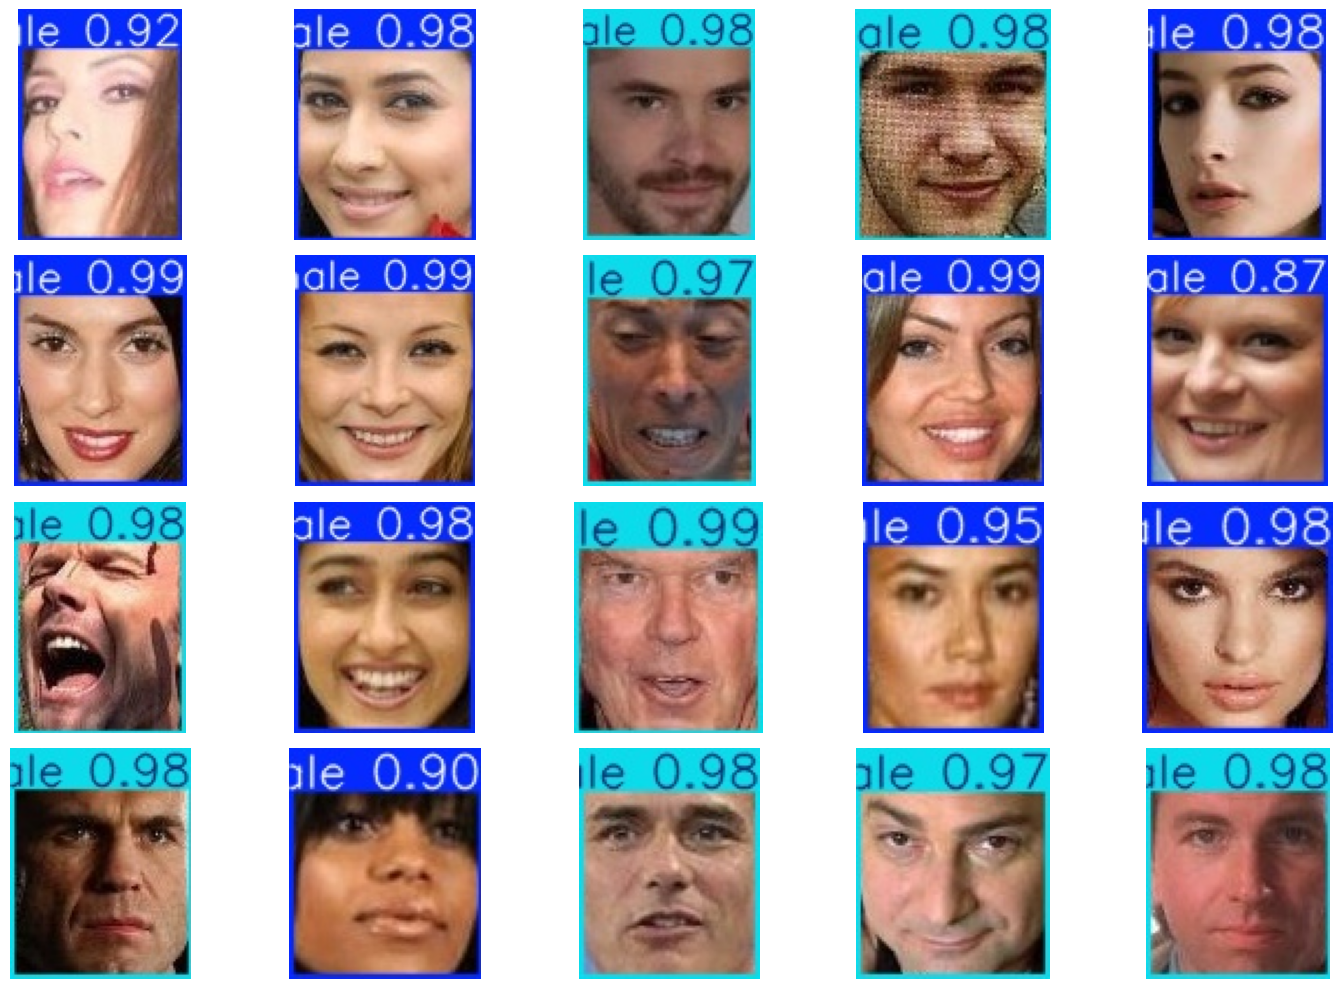

In [17]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the directory path
prediction_dir = 'runs/detect/train23'

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(prediction_dir) if f.endswith(('.jpg', '.png'))]

# Display only the first 20 images (or fewer if there are less than 20)
num_images_to_display = min(20, len(image_files))

# Define the grid layout (e.g., 4 rows and 5 columns)
num_rows = 4
num_cols = 5

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))  # Adjust figsize as needed

# Iterate through the images and display them in the grid
for i in range(num_images_to_display):
    image_path = os.path.join(prediction_dir, image_files[i])
    img = Image.open(image_path)

    # Get the current row and column index
    row = i // num_cols
    col = i % num_cols

    # Display the image on the corresponding subplot
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # Turn off axis labels and ticks

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the figure

In [28]:
# Install GitPython
!pip install gitpython

import os
from git import Repo
from shutil import copytree, copy

# Define repository URL and local directory
repo_url = "https://github.com/Dhanush-S-Gowda/GenderClassifierYolo.git"
repo_dir = "/content/GenderClassifierYolo"

# Clone your GitHub repository
if not os.path.exists(repo_dir):
    Repo.clone_from(repo_url, repo_dir)

# Change to the repository directory
os.chdir(repo_dir)

# Add a .gitignore file to exclude unnecessary files
gitignore_content = """
# Ignore Jupyter Notebook checkpoints
.ipynb_checkpoints/

# Ignore unnecessary system files
__pycache__/
*.pyc
*.pyo
*.pyd
*.swp
.DS_Store

# Ignore dataset and large files
*.zip
*.tar
*.tar.gz
*.rar

# Ignore any temporary runs or logs
runs/
sample_data/
gender-classification-dataset/
"""
with open(".gitignore", "w") as f:
    f.write(gitignore_content)

# Copy necessary files to the repository directory
necessary_files = [
    ("/content/yolov8n.pt", "models/yolov8n.pt"),  # Trained YOLOv8 model
    ("/content/yolo11n.pt", "models/yolo11n.pt"),  # Additional YOLOv8 model if relevant
    ("/content/gender-classification-dataset.zip", "datasets/gender-classification-dataset.zip"),  # Dataset archive
]

# Create directories for organization
os.makedirs("models", exist_ok=True)
os.makedirs("datasets", exist_ok=True)
os.makedirs("scripts", exist_ok=True)

for src, dest in necessary_files:
    if os.path.exists(src):
        copy(src, dest)

# Save scripts or additional necessary files
script_content = """
# Sample script to load and use the YOLO model
import torch
from ultralytics import YOLO

# Load the trained YOLOv8 model
model_path = "models/yolov8n.pt"
model = YOLO(model_path)

# Example inference
results = model.predict(source="path_to_image_or_video")
print(results)
"""
with open("scripts/load_and_infer.py", "w") as f:
    f.write(script_content)

# Initialize Git repository and configure user
repo = Repo(repo_dir)
config_writer = repo.config_writer()
config_writer.set_value("user", "name", "Dhanush S Gowda").release()
config_writer.set_value("user", "email", "dhanushsgowda277@gmail.com").release()

# Stage, commit, and push changes
repo.git.add(all=True)
repo.index.commit("Add trained YOLOv8 models and related scripts")
origin = repo.remote(name="origin")
origin.push()


NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968